# <span style='font-family:Georgia'> <span style='color:blue'> Deep Learning Tutorial Session - 22nd March 2024

### Agenda - 
- Exploring ImageNet Dataset.
- Implementing a Simple CNN for classifying the Imagenette Dataset.
- Transfer Learning using VGG19 for classifying the Imagenette Dataset.

---

## <span style='font-family:Georgia'> <span style='color:green'> Exploring the ImageNet Dataset
    
![image.png](https://production-media.paperswithcode.com/datasets/ImageNet-0000000008-f2e87edd_Y0fT5zg.jpg)
    
The ImageNet dataset contains **14,197,122** annotated images according to the WordNet hierarchy. Since 2010 the dataset is used in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC), a benchmark in image classification and object detection. 
    
    It has 21,841 classes. Each image is of size 224 x 224 pixels.
    
Unlike the MNIST and CIFAR-10 datasets that we have already discussed, the images in ImageNet are of decent resolution (224 x 224), and that’s what poses a challenge for us: 14 million images, each 224 by 224 pixels. Processing a dataset of this size requires a great amount of computing power in terms of CPU, GPU, and RAM.
    
More information on the dataset - https://paperswithcode.com/dataset/imagenet

---

## <span style='font-family:Georgia'> <span style='color:green'> Exploring the Imagenette Dataset from fastai
    
![image.png](https://production-media.paperswithcode.com/datasets/Imagenette-0000003594-e8d18761.jpg)
    
Imagenette is a subset of 10 easily classified classes from Imagenet (bench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).
    
Imagenette is a dataset that’s extracted from the large ImageNet collection of images. The reason behind releasing Imagenette is that researchers and students can practice on ImageNet-level images without needing that many computing resources.
    
Source - https://github.com/fastai/imagenette
    
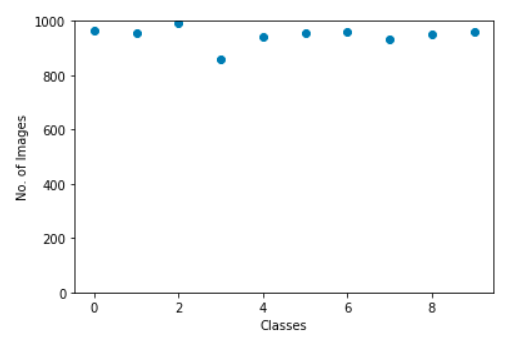

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

In [ ]:
!tar -xf imagenette2.tgz

In [ ]:
imagenette_map = { 
    "n01440764" : "tench",
    "n02102040" : "springer",
    "n02979186" : "casette_player",
    "n03000684" : "chain_saw",
    "n03028079" : "church",
    "n03394916" : "French_horn",
    "n03417042" : "garbage_truck",
    "n03425413" : "gas_pump",
    "n03445777" : "golf_ball",
    "n03888257" : "parachute"
}

---

## <span style='font-family:Georgia'> <span style='color:green'> Implementing a Simple CNN for classifying the Imagenette Dataset.
    


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create a new generator
imagegen = ImageDataGenerator()
# load train data
train = imagegen.flow_from_directory("/kaggle/working/imagenette2/train/", class_mode="categorical", shuffle=False, batch_size=128, target_size=(224, 224))
# load val data
val = imagegen.flow_from_directory("/kaggle/working/imagenette2/val/", class_mode="categorical", shuffle=False, batch_size=128, target_size=(224, 224))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

# build a sequential model
model = Sequential()
model.add(InputLayer(shape=(224, 224, 3)))

# 1st conv block
model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())
# 3rd conv block
model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())
# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(units=10, activation='softmax'))

model.summary()

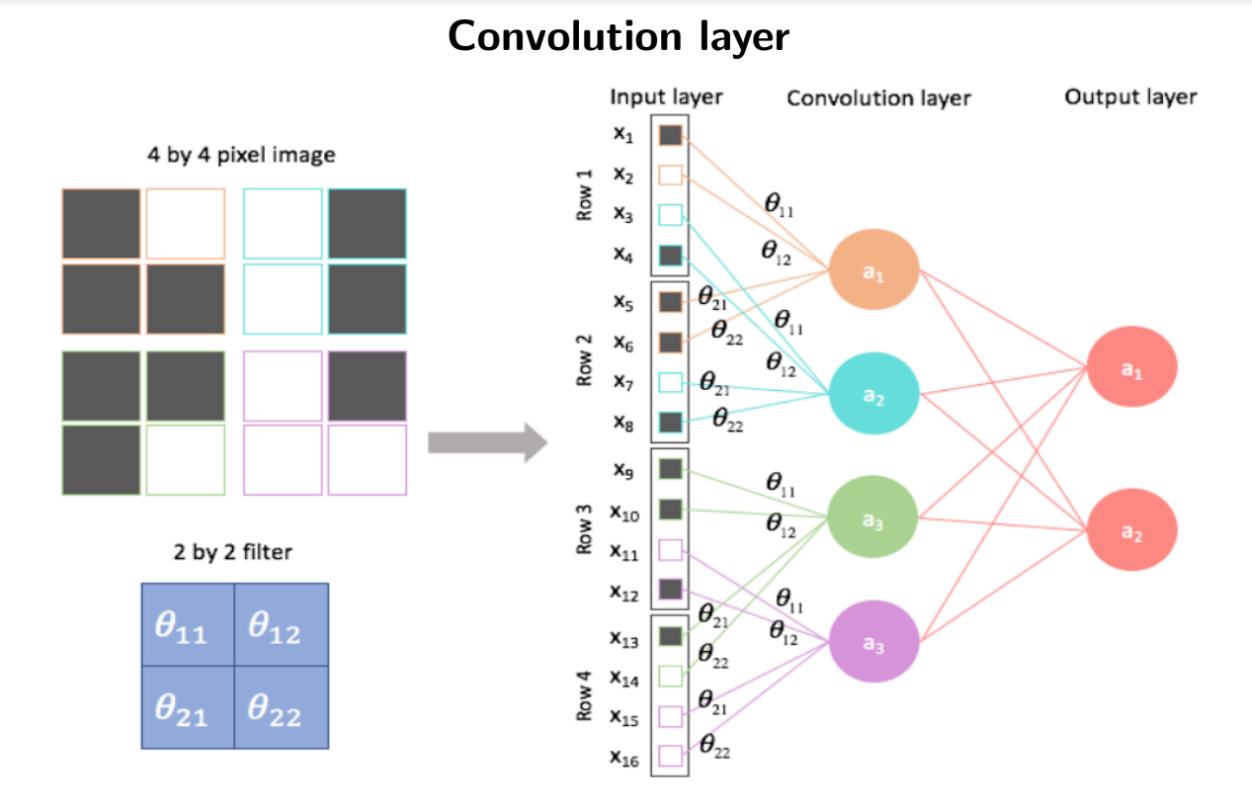

In [ ]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
# fit on data for 25 epochs
history = model.fit(train, epochs=25, validation_data=val)

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 3))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left') 

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')  

plt.show()

---

## <span style='font-family:Georgia'> <span style='color:green'> Transfer Learning using VGG16 for classifying the Imagenette Dataset.

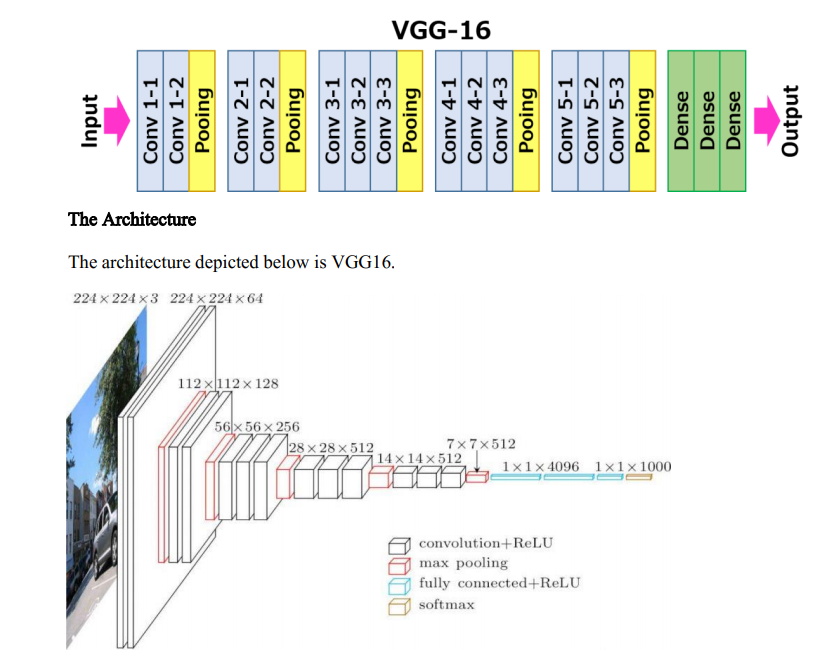

VGG16 is a CNN architecture that was the first runner-up in the 2014 ImageNet Challenge. It’s designed by the Visual Graphics Group at Oxford and has 16 layers in total, with 13 convolutional layers themselves. We will load the pre-trained weights of this model so that we can utilize the useful features this model has learned for our task.

- Downloading the Weights of VGG16

In [ ]:
from keras.applications import VGG16

pretrained_model_full = VGG16(include_top=True, weights='imagenet',input_shape=(224,224,3))
pretrained_model_full.summary()

In [ ]:
# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
pretrained_model.summary()

- Generate Features from VGG16

In [ ]:
from keras.utils import to_categorical
# extract train and val features
vgg_features_train = pretrained_model.predict(train)
vgg_features_val = pretrained_model.predict(val)

In [ ]:
# OHE target column
train_target = to_categorical(train.labels)
val_target = to_categorical(val.labels)

- Classify the images using the features from VGG16

In [ ]:
model2 = Sequential()
model2.add(Flatten(input_shape=(7,7,512)))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(10, activation='softmax'))

# compile the model
model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

model2.summary()

In [ ]:
# train model using features generated from VGG16 model
history_1 = model2.fit(vgg_features_train, train_target, epochs=25, batch_size=128, validation_data=(vgg_features_val, val_target))

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 3))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])  
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left') 

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])  
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')  

plt.show()

___